In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the CSV file
df = pd.read_csv("diabetes.csv")

# Quick look at the data
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Interaction features
df['Age_BMI'] = df['Age'] * df['BMI']
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Pregnancies_Glucose'] = df['Pregnancies'] * df['Glucose']


In [4]:
selected_features = ['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'Age',
                     'Age_BMI', 'Glucose_BMI', 'Pregnancies_Glucose']

X = df[selected_features]
y = df['Outcome']


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                    param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)


Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7540717046514727


In [8]:
best_model = LogisticRegression(**grid.best_params_, class_weight='balanced', random_state=42)
best_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


Accuracy: 0.7337662337662337


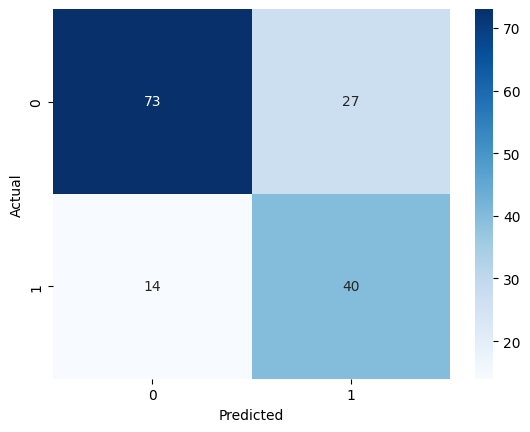

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       100
           1       0.60      0.74      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.74      0.72       154
weighted avg       0.75      0.73      0.74       154



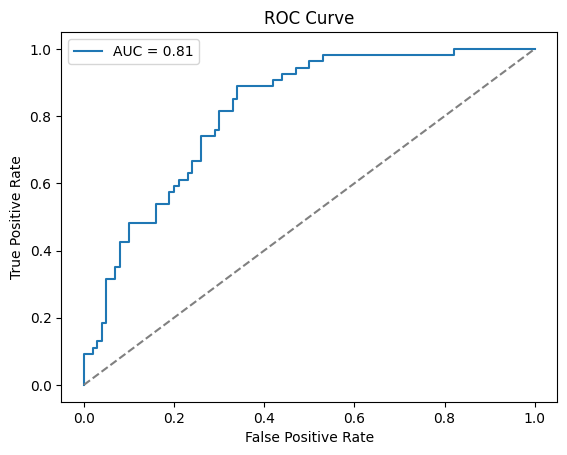

In [9]:
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:,1]

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="AUC = "+str(round(roc_auc_score(y_test, y_pred_prob),2)))
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [10]:
feature_importance = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": best_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print(feature_importance)


                    Feature  Coefficient
0                   Glucose     0.674207
6               Glucose_BMI     0.417728
1                       BMI     0.307496
3  DiabetesPedigreeFunction     0.262192
2               Pregnancies     0.248275
5                   Age_BMI     0.136558
4                       Age     0.116699
7       Pregnancies_Glucose     0.093017
